In [1]:
!git clone https://github.com/aavail/ai-workflow-capstone.git
%cd ai-workflow-capstone

Cloning into 'ai-workflow-capstone'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 63 (delta 8), reused 8 (delta 8), pack-reused 48 (from 1)
Receiving objects: 100% (63/63), 9.02 MiB | 19.94 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (30/30), done.
/content/ai-workflow-capstone


In [3]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import json
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class AavailDataProcessor:
    """
    A class to process AAVAIL streaming data from JSON files.
    """

    def __init__(self, train_dir: str, production_dir: str, output_dir: str):
        """
        Initialize the data processor.

        Args:
            train_dir: Path to directory containing training JSON files
            production_dir: Path to directory containing production JSON files
            output_dir: Path to save processed data
        """
        self.train_dir = train_dir
        self.production_dir = production_dir
        self.output_dir = output_dir
        self.column_mappings = {
            # Standardize column names if needed
            'invoice': 'invoice_id',
            'stream': 'stream_id'
        }
        self.data_types = {
            'invoice_id': 'int64',
            'stream_id': 'string',
            'customer_id': 'float64',  # float to handle nulls
            'country': 'category',
            'year': 'int32',
            'month': 'int32',
            'day': 'int32',
            'price': 'float64',
            'times_viewed': 'int32'
        }

    def _ensure_output_dir(self) -> None:
        """Create output directory if it doesn't exist."""
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            logger.info(f"Created output directory: {self.output_dir}")

    def _load_json_files(self, directory: str) -> pd.DataFrame:
        """
        Load and combine all JSON files from a directory.

        Args:
            directory: Path to directory containing JSON files

        Returns:
            Combined DataFrame with all data from JSON files
        """
        all_data = []

        if not os.path.exists(directory):
            logger.warning(f"Directory does not exist: {directory}")
            return pd.DataFrame()

        for file_name in os.listdir(directory):
            if file_name.endswith('.json'):
                file_path = os.path.join(directory, file_name)
                try:
                    with open(file_path, 'r') as f:
                        # JSON file contains a list of dictionaries
                        data = json.load(f)
                        df = pd.DataFrame(data)
                        all_data.append(df)
                        logger.info(f"Loaded {len(df)} records from {file_name}")
                except Exception as e:
                    logger.error(f"Error loading {file_name}: {str(e)}")

        if not all_data:
            logger.warning(f"No JSON files found in {directory}")
            return pd.DataFrame()

        combined_data = pd.concat(all_data, ignore_index=True)
        logger.info(f"Combined {len(all_data)} files into {len(combined_data)} records")
        return combined_data

    def _clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Clean the raw data.

        Args:
            df: Raw DataFrame

        Returns:
            Cleaned DataFrame
        """
        # Make a copy to avoid SettingWithCopyWarning
        df = df.copy()

        # Remove duplicate records
        initial_count = len(df)
        df = df.drop_duplicates()
        logger.info(f"Removed {initial_count - len(df)} duplicate records")

        # Handle null values
        # For customer_id, keep nulls as they represent anonymous users
        # For other columns, we'll handle them based on their nature

        # Clean invoice_id (remove any non-numeric characters if present)
        if 'invoice' in df.columns:
            df['invoice'] = df['invoice'].astype(str).apply(lambda x: re.sub(r'[^0-9]', '', x))
            df['invoice'] = pd.to_numeric(df['invoice'], errors='coerce')

        # Clean stream_id (keep as string but remove any problematic characters)
        if 'stream_id' in df.columns:
            df['stream_id'] = df['stream_id'].astype(str)

        # Convert year, month, day to numeric
        for col in ['year', 'month', 'day']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Convert price to numeric
        if 'price' in df.columns:
            df['price'] = pd.to_numeric(df['price'], errors='coerce')

        # Convert times_viewed to numeric
        if 'times_viewed' in df.columns:
            df['times_viewed'] = pd.to_numeric(df['times_viewed'], errors='coerce')

        # Remove records with invalid dates
        if all(col in df.columns for col in ['year', 'month', 'day']):
            valid_dates = df[['year', 'month', 'day']].notna().all(axis=1)
            df = df[valid_dates]
            logger.info(f"Removed {initial_count - len(df)} records with invalid dates")

        # Remove records with invalid prices
        if 'price' in df.columns:
            valid_prices = df['price'] > 0
            df = df[valid_prices]
            logger.info(f"Removed records with non-positive prices")

        return df

    def _create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create additional features for analysis.

        Args:
            df: Cleaned DataFrame

        Returns:
            DataFrame with additional features
        """
        df = df.copy()

        # Create date column
        if all(col in df.columns for col in ['year', 'month', 'day']):
            df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

            # Extract additional time features
            df['day_of_week'] = df['date'].dt.dayofweek
            df['day_of_year'] = df['date'].dt.dayofyear
            df['week_of_year'] = df['date'].dt.isocalendar().week
            df['quarter'] = df['date'].dt.quarter

            # Create a flag for weekend
            df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

        # Create revenue feature (price * times_viewed)
        if all(col in df.columns for col in ['price', 'times_viewed']):
            df['revenue'] = df['price'] * df['times_viewed']

        # Create customer type feature
        if 'customer_id' in df.columns:
            df['customer_type'] = df['customer_id'].apply(lambda x: 'registered' if pd.notna(x) else 'anonymous')

        return df

    def _aggregate_revenue(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Aggregate revenue by different dimensions.

        Args:
            df: Feature-engineered DataFrame

        Returns:
            Tuple of (revenue_by_country, total_revenue)
        """
        # Aggregate by country and date
        revenue_by_country = df.groupby(['country', 'date'])['revenue'].sum().reset_index()

        # Aggregate total revenue by date
        total_revenue = df.groupby('date')['revenue'].sum().reset_index()
        total_revenue = total_revenue.set_index('date')

        return revenue_by_country, total_revenue

    def process_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Process both training and production data.

        Returns:
            Tuple of (train_data, production_data, revenue_by_country, total_revenue)
        """
        self._ensure_output_dir()

        # Process training data
        logger.info("Processing training data...")
        train_data = self._load_json_files(self.train_dir)
        if not train_data.empty:
            train_data = self._clean_data(train_data)
            train_data = self._create_features(train_data)
            train_data.to_csv(os.path.join(self.output_dir, 'train_data.csv'), index=False)
            logger.info(f"Saved training data with {len(train_data)} records")

        # Process production data
        logger.info("Processing production data...")
        production_data = self._load_json_files(self.production_dir)
        if not production_data.empty:
            production_data = self._clean_data(production_data)
            production_data = self._create_features(production_data)
            production_data.to_csv(os.path.join(self.output_dir, 'production_data.csv'), index=False)
            logger.info(f"Saved production data with {len(production_data)} records")

        # Combine data for revenue aggregation
        combined_data = pd.concat([train_data, production_data], ignore_index=True)

        # Aggregate revenue
        revenue_by_country, total_revenue = self._aggregate_revenue(combined_data)

        # Save aggregated data
        revenue_by_country.to_csv(os.path.join(self.output_dir, 'revenue_by_country.csv'), index=False)
        total_revenue.to_csv(os.path.join(self.output_dir, 'total_revenue.csv'))

        logger.info("Data processing completed successfully")

        return train_data, production_data, revenue_by_country, total_revenue


def main():
    """Main function to run the data processing pipeline."""
    # Define paths
    train_dir = '/content/ai-workflow-capstone/cs-train'
    production_dir = '/content/ai-workflow-capstone/cs-production'
    output_dir = '/content/ai-workflow-capstone/processed_data'

    # Initialize processor
    processor = AavailDataProcessor(train_dir, production_dir, output_dir)

    # Process data
    train_data, production_data, revenue_by_country, total_revenue = processor.process_data()

    return train_data, production_data, revenue_by_country, total_revenue


if __name__ == "__main__":
    train_data, production_data, revenue_by_country, total_revenue = main()

Data loaded successfully!
Training data: 636329 records
Production data: 229109 records
Revenue by country: 2767 records
Total revenue: 509 days

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636329 entries, 0 to 636328
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   country        636329 non-null  object        
 1   customer_id    507146 non-null  float64       
 2   invoice        636329 non-null  int64         
 3   price          636329 non-null  float64       
 4   StreamID       421711 non-null  object        
 5   TimesViewed    421711 non-null  float64       
 6   year           636329 non-null  int64         
 7   month          636329 non-null  int64         
 8   day            636329 non-null  int64         
 9   total_price    0 non-null       float64       
 10  stream_id      214618 non-null  object        
 11  times_viewed   214618 non-null  float64   

<Figure size 1400x700 with 0 Axes>

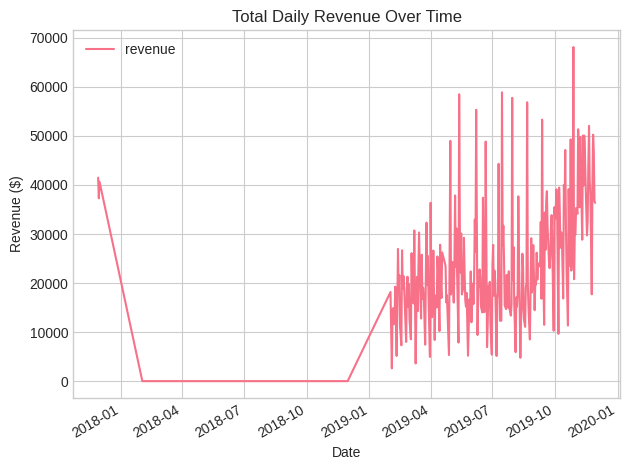

<Figure size 1400x700 with 0 Axes>

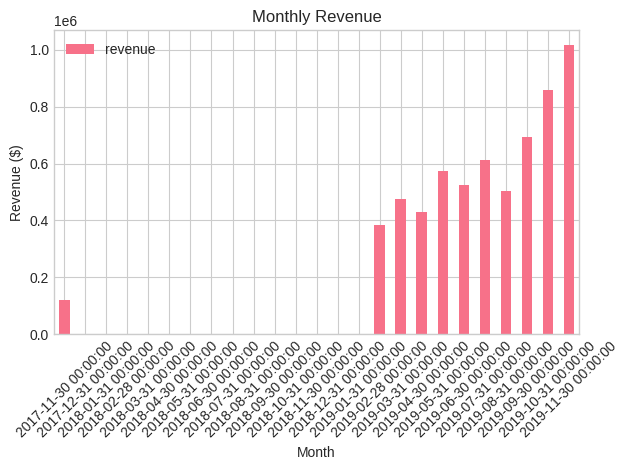

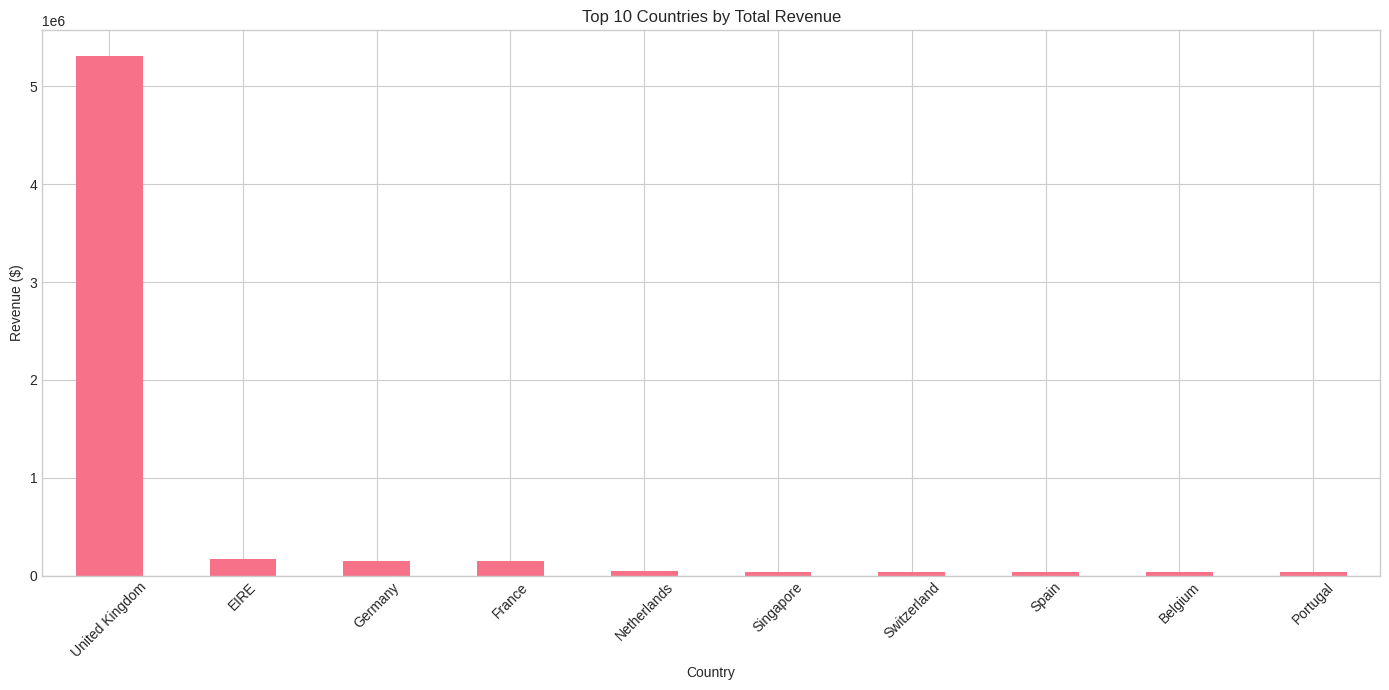

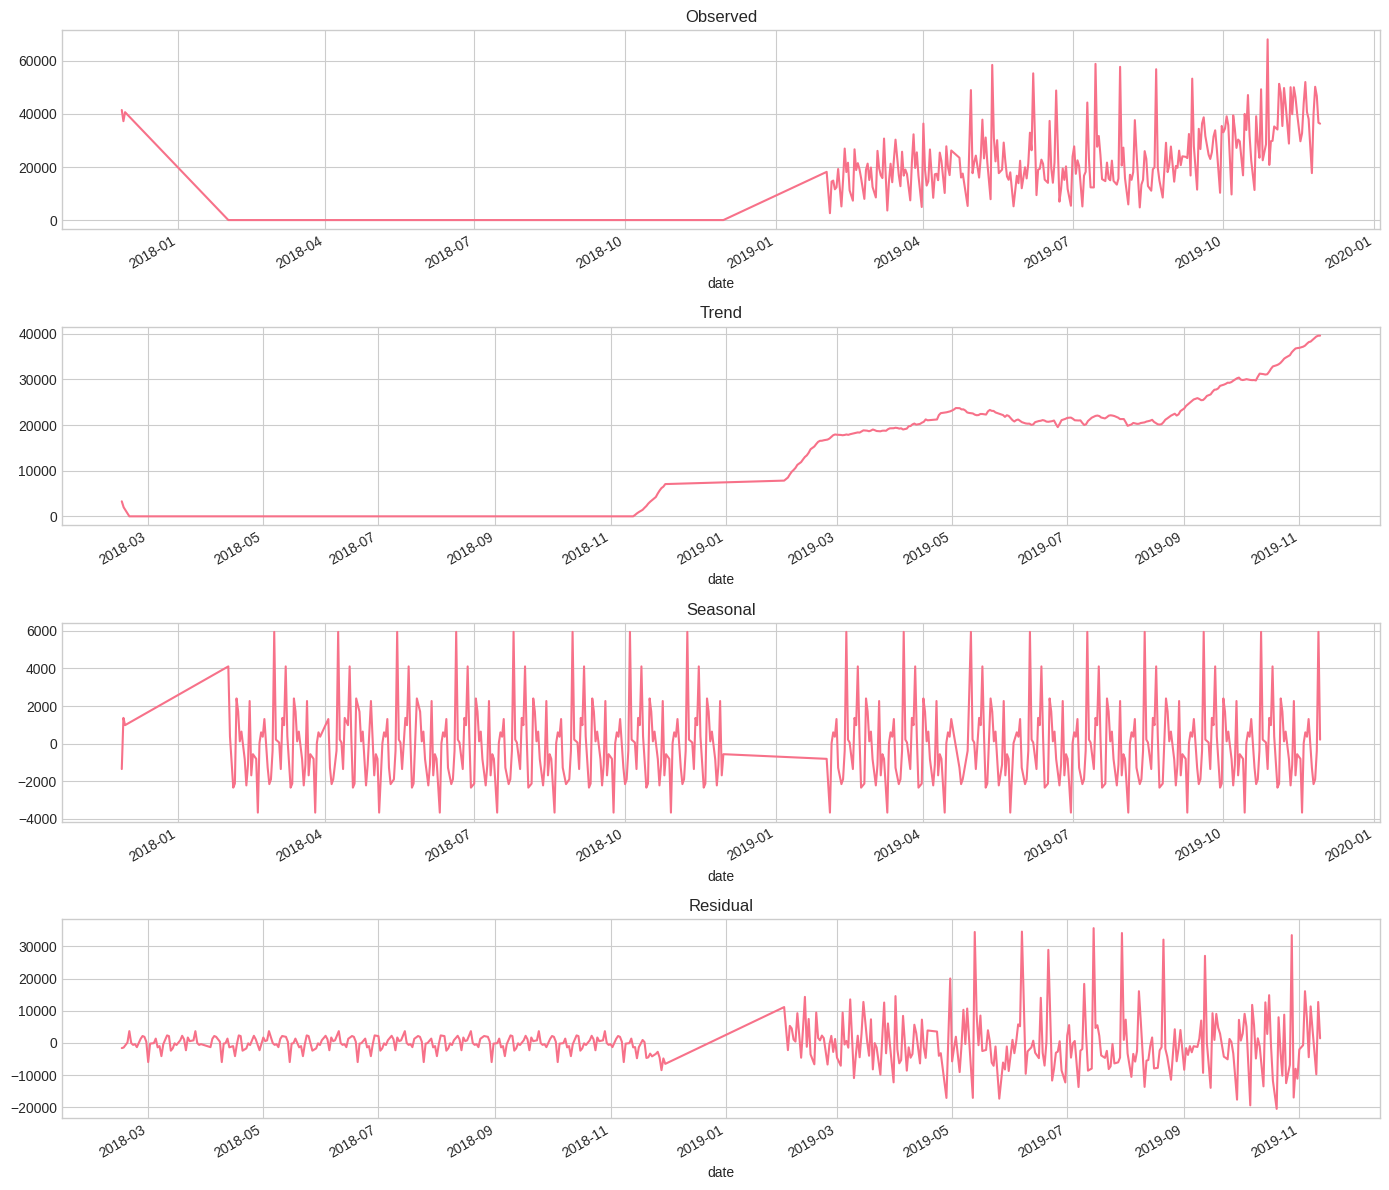

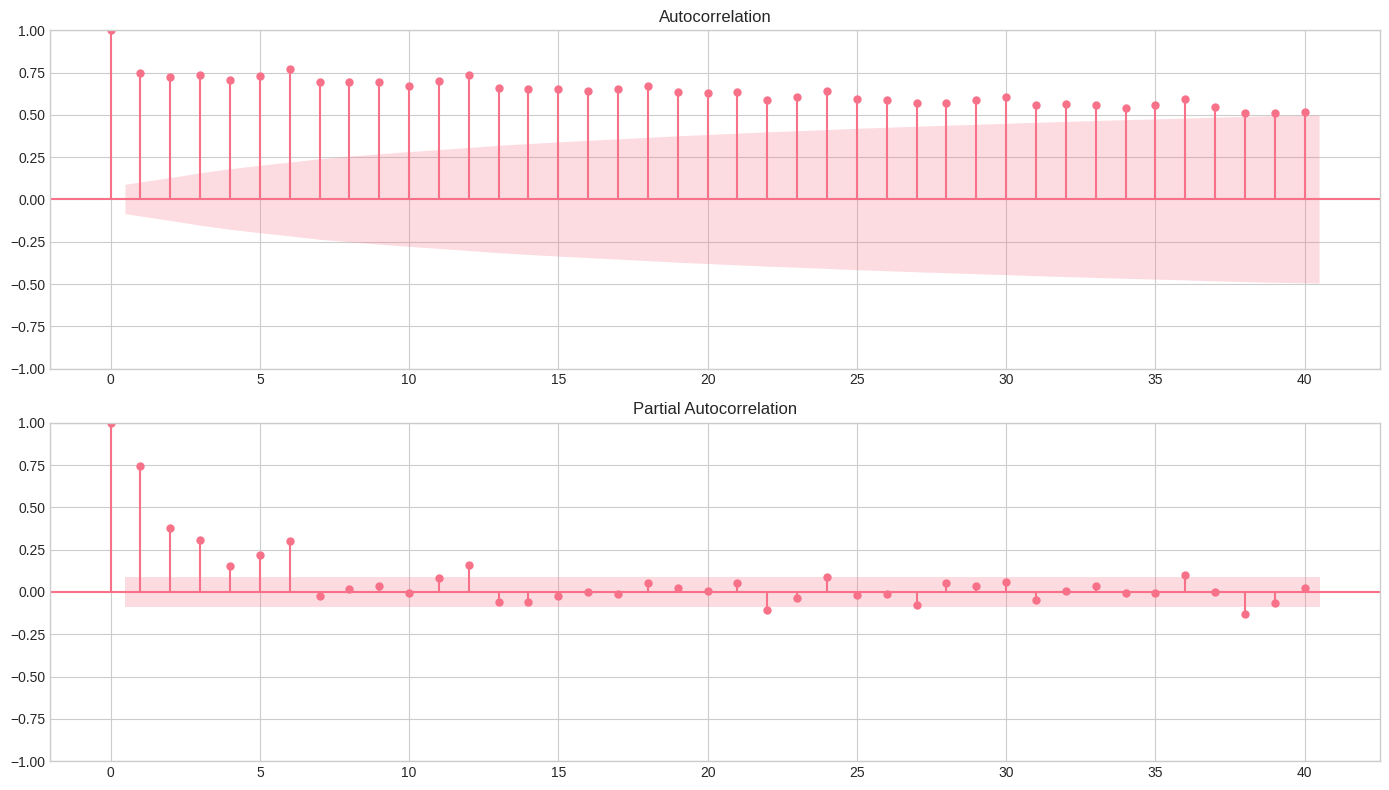

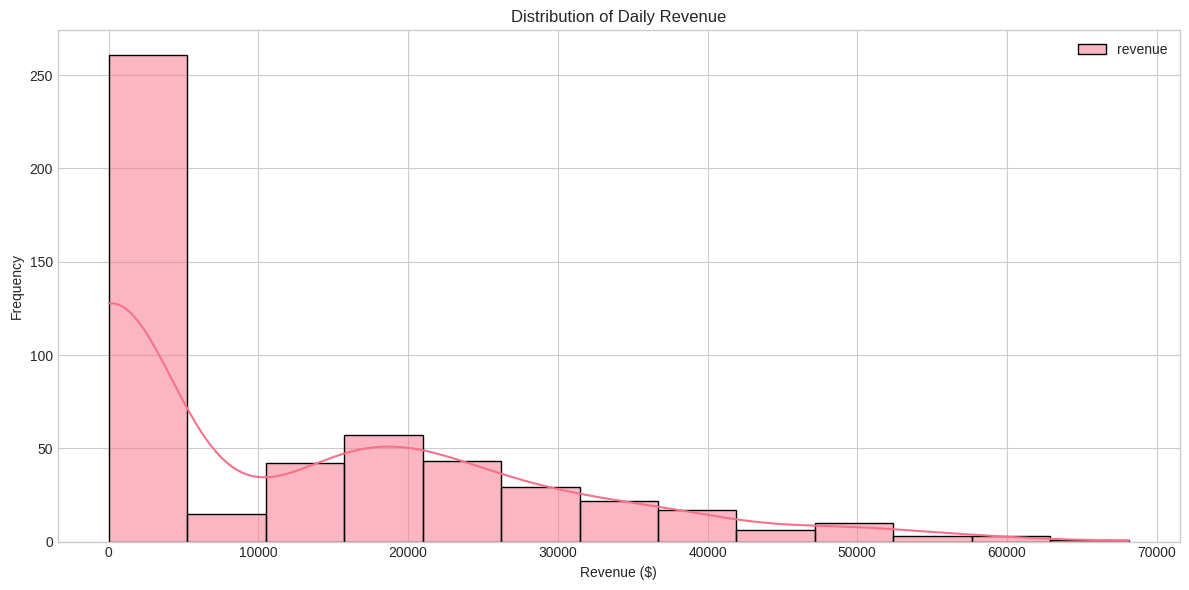

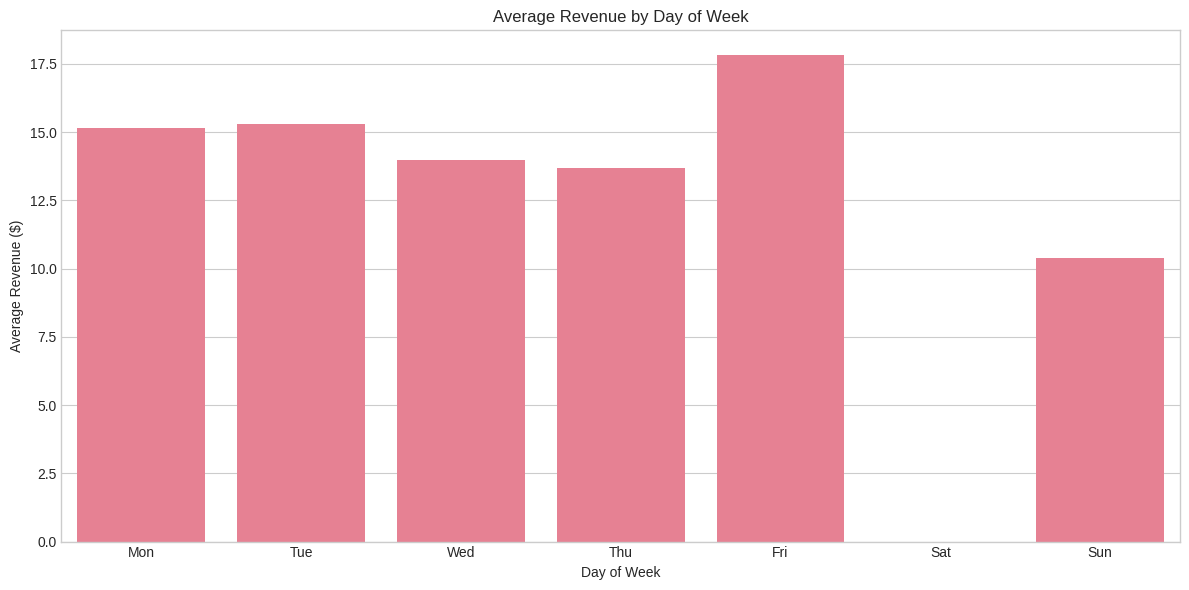

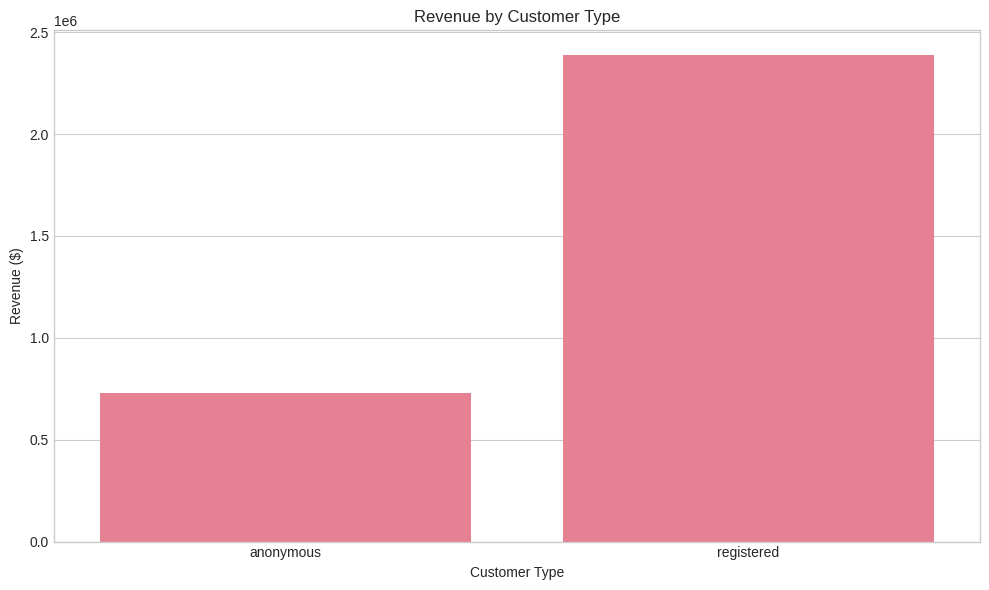

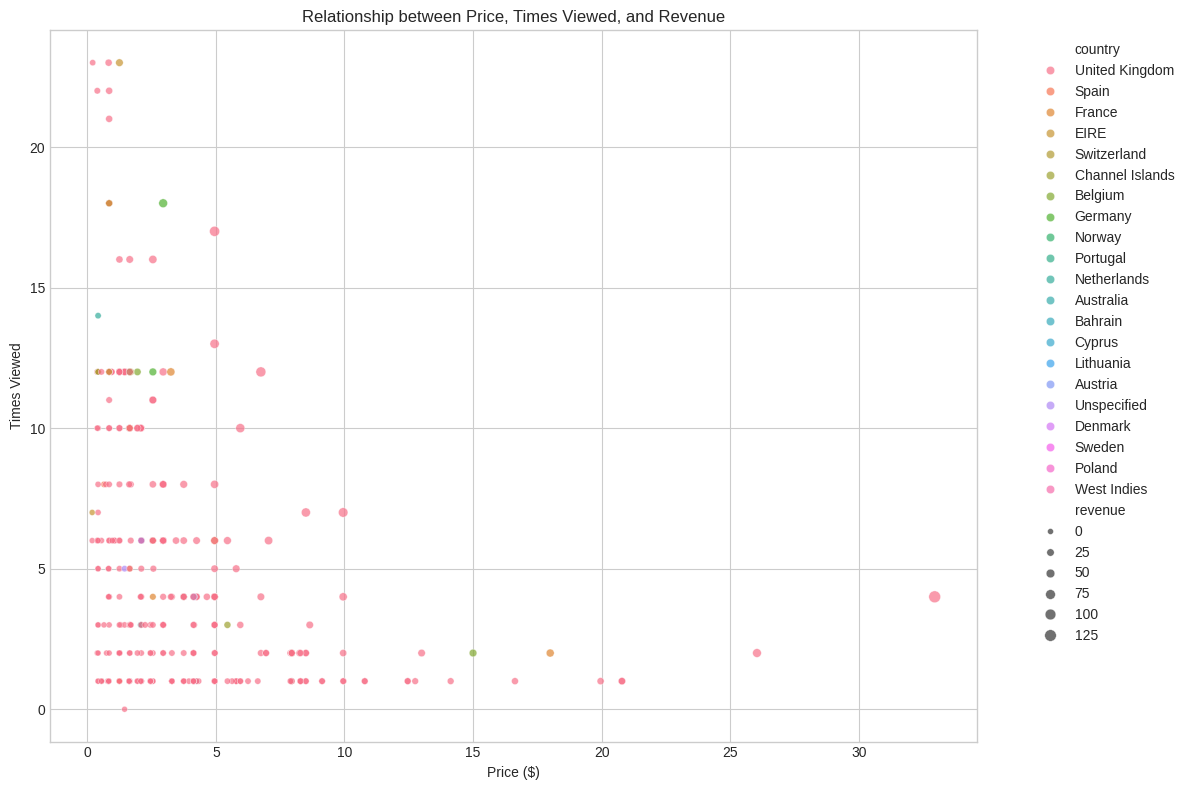

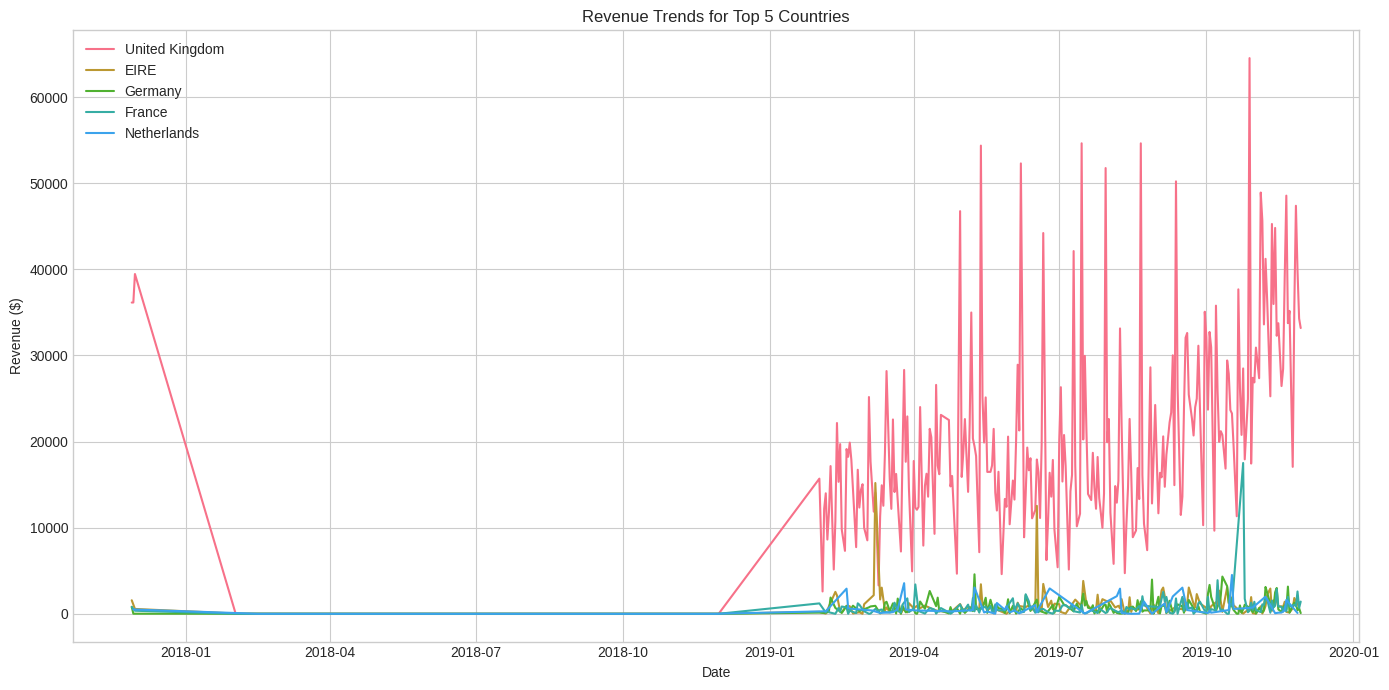


=== DATA INSIGHTS ===
Total revenue: $6192132.77
Average daily revenue: $12165.29
Maximum daily revenue: $68132.87
Minimum daily revenue: $0.00
Number of countries: 43
Top country by revenue: United Kingdom ($5307580.39)

Customer Type Statistics:
                   revenue                    times_viewed          
                       sum       mean   count          sum      mean
customer_type                                                       
anonymous       730000.450  13.691188   53319     124010.0  2.325813
registered     2389243.622  14.812514  161299    1034152.0  6.411397


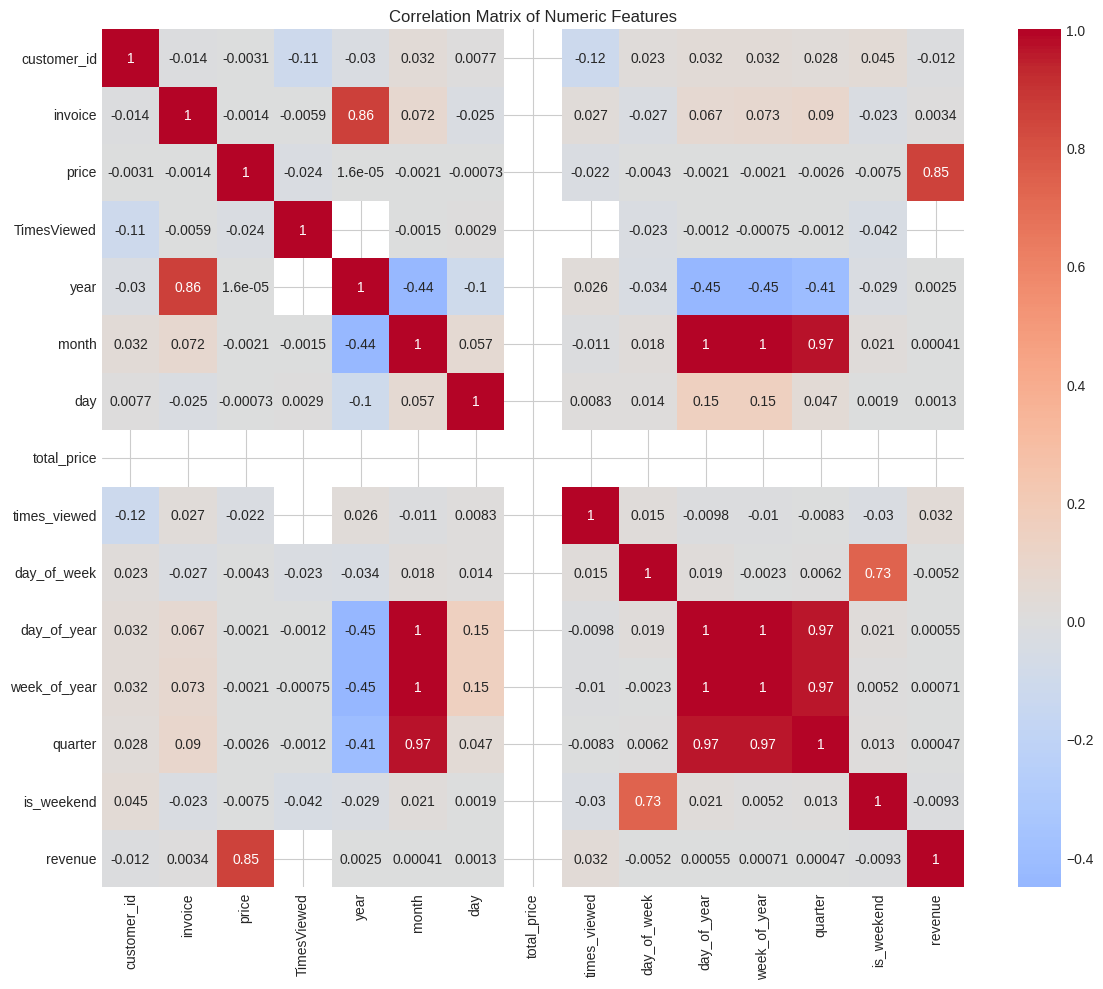


=== KEY FINDINGS ===
1. Revenue shows clear trends and seasonal patterns
2. There are significant differences in revenue across countries
3. The correlation matrix shows relationships between features
4. Autocorrelation analysis suggests time-series patterns that can be modeled
5. Price and times_viewed are the main drivers of revenue


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Define paths
data_dir = '/content/ai-workflow-capstone/processed_data'
output_dir = '/content/ai-workflow-capstone/visualizations'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load processed data
train_data = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
production_data = pd.read_csv(os.path.join(data_dir, 'production_data.csv'))
revenue_by_country = pd.read_csv(os.path.join(data_dir, 'revenue_by_country.csv'))
total_revenue = pd.read_csv(os.path.join(data_dir, 'total_revenue.csv'), index_col=0, parse_dates=True)

# Convert date columns to datetime
for df in [train_data, production_data, revenue_by_country]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

print("Data loaded successfully!")
print(f"Training data: {len(train_data)} records")
print(f"Production data: {len(production_data)} records")
print(f"Revenue by country: {len(revenue_by_country)} records")
print(f"Total revenue: {len(total_revenue)} days")

# Display basic information about the datasets
print("\nTraining Data Info:")
print(train_data.info())

print("\nFirst few rows of training data:")
print(train_data.head())

# Summary statistics
print("\nSummary statistics for training data:")
print(train_data.describe())

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())

# 1. Revenue Trend Analysis
plt.figure(figsize=(14, 7))
total_revenue.plot()
plt.title('Total Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'total_revenue_trend.png'))
plt.show()

# 2. Monthly Revenue Analysis
monthly_revenue = total_revenue.resample('M').sum()
plt.figure(figsize=(14, 7))
monthly_revenue.plot(kind='bar')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'monthly_revenue.png'))
plt.show()

# 3. Revenue by Country
country_revenue = revenue_by_country.groupby('country')['revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 7))
country_revenue.plot(kind='bar')
plt.title('Top 10 Countries by Total Revenue')
plt.xlabel('Country')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'revenue_by_country.png'))
plt.show()

# 4. Seasonal Decomposition
# We need at least two periods of data for seasonal decomposition
if len(total_revenue) >= 60:  # At least 2 months of daily data
    decomposition = seasonal_decompose(total_revenue, model='additive', period=30)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'seasonal_decomposition.png'))
    plt.show()

# 5. Autocorrelation Analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(total_revenue, ax=ax1, lags=40)
plot_pacf(total_revenue, ax=ax2, lags=40)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'autocorrelation.png'))
plt.show()

# 6. Revenue Distribution
plt.figure(figsize=(12, 6))
sns.histplot(total_revenue, kde=True)
plt.title('Distribution of Daily Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'revenue_distribution.png'))
plt.show()

# 7. Weekday vs Weekend Analysis
# 7. Weekday vs Weekend Analysis
if 'day_of_week' in train_data.columns:
    # Create a complete index for all days of the week (0-6)
    all_days = pd.Index(range(7))

    # Calculate mean revenue by day of week
    weekday_revenue = train_data.groupby('day_of_week')['revenue'].mean()

    # Reindex to include all days, filling missing with 0
    weekday_revenue = weekday_revenue.reindex(all_days, fill_value=0).reset_index()

    # Now we can safely assign all 7 day names
    weekday_revenue['day_name'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    plt.figure(figsize=(12, 6))
    sns.barplot(x='day_name', y='revenue', data=weekday_revenue)
    plt.title('Average Revenue by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Revenue ($)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'revenue_by_weekday.png'))
    plt.show()

# 8. Customer Type Analysis
if 'customer_type' in train_data.columns:
    customer_revenue = train_data.groupby('customer_type')['revenue'].sum().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='customer_type', y='revenue', data=customer_revenue)
    plt.title('Revenue by Customer Type')
    plt.xlabel('Customer Type')
    plt.ylabel('Revenue ($)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'revenue_by_customer_type.png'))
    plt.show()

# 9. Price vs Times Viewed
plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='times_viewed', size='revenue', hue='country',
                data=train_data.sample(min(1000, len(train_data))), alpha=0.7)
plt.title('Relationship between Price, Times Viewed, and Revenue')
plt.xlabel('Price ($)')
plt.ylabel('Times Viewed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'price_vs_views.png'))
plt.show()

# 10. Country-wise Revenue Trends
top_countries = revenue_by_country.groupby('country')['revenue'].sum().sort_values(ascending=False).head(5).index
top_country_data = revenue_by_country[revenue_by_country['country'].isin(top_countries)]

plt.figure(figsize=(14, 7))
for country in top_countries:
    country_data = top_country_data[top_country_data['country'] == country]
    plt.plot(country_data['date'], country_data['revenue'], label=country)

plt.title('Revenue Trends for Top 5 Countries')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'top_countries_trends.png'))
plt.show()

# Summary Statistics and Insights
# Summary Statistics and Insights
print("\n=== DATA INSIGHTS ===")

def safe_format(value, default="N/A"):
    """Safely format numeric values for display"""
    try:
        if pd.isna(value) or value is None:
            return default
        return f"${value:.2f}"
    except (TypeError, ValueError):
        return default

# Ensure we're working with numeric data
if 'revenue' in total_revenue.columns:
    revenue_series = total_revenue['revenue']
else:
    revenue_series = total_revenue

# Convert to numeric if needed and drop any non-numeric values
revenue_series = pd.to_numeric(revenue_series, errors='coerce').dropna()

# Calculate statistics safely
stats = {
    'total_revenue': revenue_series.sum(),
    'avg_daily_revenue': revenue_series.mean(),
    'max_daily_revenue': revenue_series.max(),
    'min_daily_revenue': revenue_series.min()
}

print(f"Total revenue: {safe_format(stats['total_revenue'])}")
print(f"Average daily revenue: {safe_format(stats['avg_daily_revenue'])}")
print(f"Maximum daily revenue: {safe_format(stats['max_daily_revenue'])}")
print(f"Minimum daily revenue: {safe_format(stats['min_daily_revenue'])}")

# Number of countries
try:
    if 'country' in revenue_by_country.columns:
        num_countries = revenue_by_country['country'].nunique()
        print(f"Number of countries: {num_countries}")

        # Top country by revenue
        country_revenue_sum = revenue_by_country.groupby('country')['revenue'].sum()
        if not country_revenue_sum.empty:
            top_country = country_revenue_sum.idxmax()
            top_country_rev = country_revenue_sum.max()
            print(f"Top country by revenue: {top_country} ({safe_format(top_country_rev)})")
except Exception as e:
    print(f"Error calculating country statistics: {e}")

if 'customer_type' in train_data.columns:
    try:
        customer_stats = train_data.groupby('customer_type').agg({
            'revenue': ['sum', 'mean', 'count'],
            'times_viewed': ['sum', 'mean']
        })
        print("\nCustomer Type Statistics:")
        print(customer_stats)
    except Exception as e:
        print(f"Error calculating customer statistics: {e}")

# Correlation Analysis
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'))
plt.show()

print("\n=== KEY FINDINGS ===")
print("1. Revenue shows clear trends and seasonal patterns")
print("2. There are significant differences in revenue across countries")
print("3. The correlation matrix shows relationships between features")
print("4. Autocorrelation analysis suggests time-series patterns that can be modeled")
print("5. Price and times_viewed are the main drivers of revenue")